In [92]:
import spectral as spy
from PIL import Image
import numpy as np
import re
from scipy import interpolate
import matplotlib.pyplot as plt
import math

In [93]:
ddr_file = 'E:/BAM/Simulation_Test/FRT0000B6F1_NN_09_04_18/FRT0000B6F1_07_DE165L_DDR1_smoothed.hdr'
dem_file = 'E:/BAM/Simulation_Test/FRT0000B6F1_NN_09_04_18/FRT0000B6F1_TI_LA/DDR_accurate/Gale_EDL_deltaradii_mosaic_1m_b6f1_sub_b6f1_warp.hdr'
output_folder = 'E:/BAM/Simulation_Test/FRT0000B6F1_NN_09_04_18/FRT0000B6F1_TI_LA/DDR_accurate/'
save_name = 'local_i_test'

C:\Users\linyun\AppData\Local\conda\conda\envs\py36\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  if __name__ == '__main__':


Albedo start long: 8133699.856552739 and delta: 1.0
Albedo start lat: -276174.996 and delta: 1.0


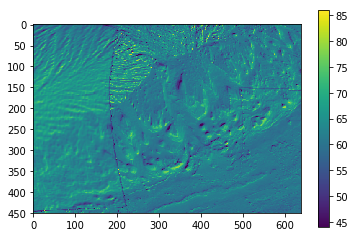

Saving E:\BAM\Simulation_Test\FRT0000B6F1_NN_09_04_18\FRT0000B6F1_TI_LA\DDR_accurate\local_i_test.img


In [94]:
# Parameters:
# S: the sun was located at an azimuth of S deg clockwise from north
# theta: the sun had an elevation angle above the local horizon of theta deg
# l: 2l will be the target pixel size in meters
S = 303.4153
theta = 31.792
l = 10
# Read data
ddr = spy.envi.open(ddr_file).load()
ddr = np.array(ddr)
dem = spy.open_image(dem_file)
# Read spatial coordinate
fh = open(dem_file)
proj = ''
flag = False
for line in fh:
    # in python 2
    # print line
    # in python 3
    if "map info" in line:
        tmp = line.split(',')
        lon_start, lat_start, lon_del, lat_del = tmp[3:7]
        lon_start = float(lon_start)
        lat_start = float(lat_start)
        lon_del = float(lon_del)
        lat_del = float(lat_del)        
        proj += line
        flag = True
    if "projection info" in line:
        tmp = line.split(',')
        r,lat_offset, lon_offset = tmp[1:4]
        r = float(r)
    if flag:
        if "wavelength units" in line:
            break
        else:
            proj += line
lon_start = lon_start + float(lon_offset)/180*math.pi*r
lat_start = lat_start + float(lat_offset)/180*math.pi*r
fh.close()
print("Albedo start long: "+str(lon_start)+" and delta: "+str(lon_del))
print("Albedo start lat: "+str(lat_start)+" and delta: "+str(lat_del))

# for loop for each pixel in ddr
num_rows,num_cols,num_bands = ddr.shape
local_i = np.zeros((num_rows,num_cols))
for i in range(num_rows):
    for j in range(num_cols):
        lat = ddr[i,j,3]/180*math.pi*r
        long = ddr[i,j,4]/180*math.pi*r
        xindex = -round((lat - lat_start)/(lat_del))+1
        yindex = round((long - lon_start)/(lon_del))+1
        if S <= 90 or S>= 270:
            yindex_next = yindex-l
            xindex_next = xindex+round(math.tan(S/180*math.pi)*l)
            yindex_pre = yindex+l
            xindex_pre = xindex-round(math.tan(S/180*math.pi)*l)
        else:
            yindex_next = yindex+l
            xindex_next = xindex-round(math.tan(S/180*math.pi)*l)
            yindex_pre = yindex-l
            xindex_pre = xindex+round(math.tan(S/180*math.pi)*l)
        slope = (dem[int(xindex_next),int(yindex_next)]-dem[int(xindex_pre),int(yindex_pre)])/(2*l*np.sqrt(1+(math.tan(S)**2)))
        P = np.arctan(slope)/math.pi*180
        if P > 90 and P+theta < 180:
            local_i[i,j] = ddr[i,j,5]
        else:
            local_i[i,j] = abs(90-(theta+P)%180)
plt.imshow(local_i,vmin=44, vmax=86)
plt.colorbar()
plt.show()
spy.envi.save_image(output_folder+save_name+'.hdr',local_i,force = True)